In [1]:
import pandas as pd
import category_encoders as ce
import numpy as np
import datetime
from collections import Counter
from geopy.distance import geodesic
from geopy.geocoders import Nominatim
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split # для разделения датасета
from sklearn import preprocessing
import warnings 
warnings.filterwarnings('ignore') 

#для эмоциональности текста
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели 

# библиотеки для визуализации 
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
# исходник 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


In [2]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [3]:
# фиксируем RANDOM_SEED, для воспроизводимости эксперимента
RANDOM_SEED = 42

In [4]:
# Подгрузим наши данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

## 1. Предобработка данных

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [7]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [8]:
# для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # данные для обучения
df_train['id'] = df_train.index
df_test['sample'] = 0 # данные для теста
df_test['id'] = df_test.index
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

hotels = pd.concat([df_test, df_train], ignore_index=True, sort=False)

In [9]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 19 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [10]:
# считаем количество дубликатов
num_duplicates = hotels.duplicated().sum() 

# вывод количества дубликатов
print("Количество дубликатов в датасете: ", num_duplicates)

Количество дубликатов в датасете:  0


In [11]:
# удалим дубликаты
hotels.drop_duplicates(inplace=True)

In [12]:
# исследуем данные на наличие пропусков
cols_null_percent = hotels.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
cols_with_null

lat    0.633655
lng    0.633655
dtype: float64

In [13]:
# поскольку привязка отеле к широте и долготе при выборе не является существенной, удалим данные.
hotels.drop(['lat', 'lng'], axis=1, inplace=True)

## 2. Разработка признаков

In [14]:
#Для информации выведем количество уникальных значений в каждом признаке
hotels.nunique(dropna=False)

hotel_address                                   1493
additional_number_of_scoring                     480
review_date                                      731
average_score                                     34
hotel_name                                      1492
reviewer_nationality                             227
negative_review                               330011
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               412601
review_total_positive_word_counts                365
total_number_of_reviews_reviewer_has_given       198
tags                                           55242
days_since_review                                731
sample                                             2
id                                            386803
reviewer_score                                    38
dtype: int64

In [15]:
hotels.describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,sample,id,reviewer_score
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000
mean,498.081836,8.397487,18.539450,2743.743944,17.776458,7.166001,0.749999,161167.375000,6.297672
std,500.538467,0.548048,29.690831,2317.464868,21.804185,11.040228,0.433014,113200.666918,3.902295
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,0.250000,64467.000000,0.625000
50%,341.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,1.000000,128934.000000,7.900000
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.000000,1.000000,257867.750000,9.600000
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,1.000000,386802.000000,10.000000


In [16]:
# Преобразуем c помощью функции признак «days_since_review» в хронологический порядок 
hotels['days_since_review'] \
    = hotels['days_since_review'].apply(lambda x: int(x.split()[0]))
hotels['day_number'] \
    = (hotels['days_since_review']-hotels['days_since_review'].max()) * (-1)

### Работа с датами

In [17]:
# Преобразуем  признак даты в datetime
hotels['review_date'] = pd.to_datetime(hotels['review_date'])
# Создадим новые признаки
hotels['review_year'] = hotels['review_date'].dt.year
hotels['review_month'] = hotels['review_date'].dt.month
hotels.drop(['review_date'], axis=1, inplace=True)

### Обработка признака 'hotel_address'

In [18]:
# извлечем из адреса страну и город отеля и запишем в новый признак. 
# добавим данные о количестве населения и площади города в отдельные признаки. Удалим исходный признак.
hotels['hotel_city'] = hotels['hotel_address'].apply(lambda x: 'London' if x.endswith('United Kingdom') else x.split()[-2])

сity_population = {
    'Paris':  2148327, 'London': 8908081, 'Milan': 1366180, 
    'Vienna': 1911191, 'Barcelona': 1636732, 'Amsterdam': 860124
}
сity_area = {
    'Paris': 105, 'London': 1706, 'Milan': 181, 
    'Vienna': 414, 'Barcelona': 101, 'Amsterdam': 219
}

hotels['сity_population'] = hotels['hotel_city'].map(сity_population)
hotels['сity_area'] = hotels['hotel_city'].map(сity_area)

### Обработка признака 'reviewer_nationality'

In [19]:
# признак страны для отелей
hotels['country'] = hotels['hotel_address'].apply(lambda x: x.split()[-1] if x.split()[-1] != 'Kingdom' \
                                                                      else ' '.join(x.split()[-2:]))

# убераем пробелы в названии места жительства резидента
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].apply(lambda x: x[1:-1])

# создадаём признак,определяющий иностранец или "местный житель  писал отзыв"
hotels['local_reviewer'] = hotels.apply(lambda x: 1 if x['reviewer_nationality'] == x['country'] 
                                                else 0, axis=1)

hotels['local_reviewer'].value_counts(normalize=True)

local_reviewer
0    0.654082
1    0.345918
Name: proportion, dtype: float64

In [20]:
hotels['reviewer_nationality'].nunique(dropna=False)

227

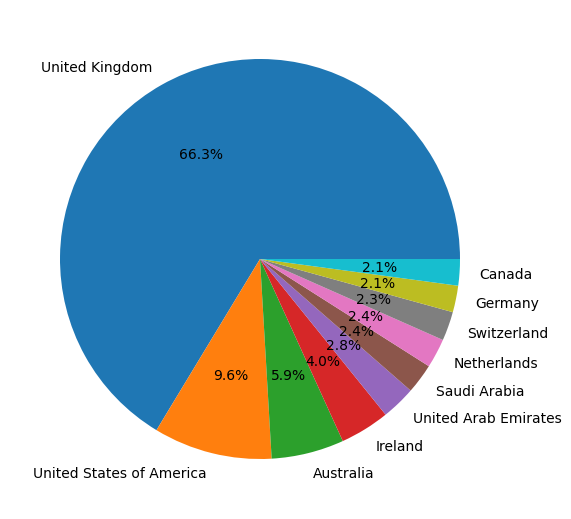

In [21]:
reviewer_data = hotels['reviewer_nationality'].value_counts().nlargest(10)
fig = plt.figure(figsize=(5, 5))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    reviewer_data,
    labels = reviewer_data.index,
    autopct = '%.1f%%'
);

### Отношение негативных и позитивных слов к общему количеству слов в отзыве.

In [22]:
# Вычисление отношения негативных и позитивных слов к общему количеству слов в отзыве
total_word_counts = hotels['review_total_negative_word_counts'] + hotels['review_total_positive_word_counts']
hotels['Negative_Word_Ratio'] = hotels['review_total_negative_word_counts'] / total_word_counts
hotels['Positive_Word_Ratio'] = hotels['review_total_positive_word_counts'] / total_word_counts

In [23]:
# Расчет соотношения положительных и отрицательных отзывов
hotels['review_sentiment_ratio'] = hotels['review_total_positive_word_counts'] / hotels['review_total_negative_word_counts']
hotels['review_sentiment_ratio'].replace(np.inf, np.nan, inplace=True)
# Вывод результатов
display(hotels[['review_total_positive_word_counts', 'review_total_negative_word_counts', 'review_sentiment_ratio']])

,review_total_positive_word_counts,review_total_negative_word_counts,review_sentiment_ratio
0,62,52,1.192308
1,0,10,0.000000
2,5,3,1.666667
3,27,0,NaN
4,7,0,NaN
...,...,...,...
515733,10,0,NaN
515734,93,0,NaN
515735,9,12,0.750000
515736,6,0,NaN


### Работа с тегами

In [24]:
# преобразование строковых переменных в списки.
hotels['tags'] = hotels['tags'].apply(lambda x: x[3:-3].split(' \', \' '))

In [25]:
# получим продолжительности пребывания.
# заполним значений NaN типичной продолжительностью пребывания в 1 день.
def get_stay(x):
    for tag in x:
        words = tag.split()
        if words[0] =='Stayed':
            return int(words[1])
    return np.NaN

hotels['night_index'] = hotels['tags'].apply(get_stay)
hotels['night_index'].fillna(1, inplace=True)

In [26]:
# запустим кодирование для наиболее частых тегов. 
# наиболее часто берется 5% от размера набора данных.
boundary = hotels.shape[0] * 0.05  # 5% граница
c = Counter(tag for row in hotels['tags'] for tag in row)
frequent_tags_count = dict(filter(lambda x: x[1] > boundary, c.items()))
print('Наиболее часто встречающиеся теги и их количество:')
frequent_tags_count

Наиболее часто встречающиеся теги и их количество:


{'Leisure trip': 417778,
 'Couple': 252294,
 'Double Room': 35207,
 'Stayed 2 nights': 133937,
 'Group': 65392,
 'Stayed 1 night': 193645,
 'Business trip': 82939,
 'Solo traveler': 108545,
 'Submitted from a mobile device': 307640,
 'Stayed 3 nights': 95821,
 'Superior Double Room': 31393,
 'Stayed 4 nights': 47817,
 'Standard Double Room': 32248,
 'Family with young children': 61015,
 'Family with older children': 26349}

In [27]:
# получим список наиболее часто встречающихся тегов
frequent_tags = list(dict(filter(lambda x: 
    x[1]>boundary and x[0].split()[0]!='Stayed',
    frequent_tags_count.items())).keys())
frequent_tags

['Leisure trip',
 'Couple',
 'Double Room',
 'Group',
 'Business trip',
 'Solo traveler',
 'Submitted from a mobile device',
 'Superior Double Room',
 'Standard Double Room',
 'Family with young children',
 'Family with older children']

## 3. Кодирование признаков

In [28]:
encoder = ce.OneHotEncoder(cols=['hotel_city']) # указываем столбец для кодирования
type_bin = encoder.fit_transform(hotels['hotel_city'])
type_bin = type_bin.rename(columns={'city_1':'London','city_2':'Paris','city_3':'Amsterdam','city_4':'Milan','city_5':'Vienna','city_6':'Barcelona'})
hotels = pd.concat([hotels, type_bin], axis=1)

In [29]:
encoder = ce.OneHotEncoder(cols=['country'])
type_bin = encoder.fit_transform(hotels['country'])
type_bin = type_bin.rename(columns={'country_1':'United Kingdom','country_2':'France','country_3':'Netherlands','country_4':'Italy','country_5':'Austria','country_6':'Spain'})
hotels = pd.concat([hotels, type_bin], axis=1)

In [30]:
# применяем бинарное колдирование к признаку 'reviewer_nationality'
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality'])
type_bin = bin_encoder.fit_transform(hotels['reviewer_nationality'])

hotels = pd.concat([hotels, type_bin], axis=1)

In [31]:
# выполним быстрое кодирование для частых тегов
for tag in frequent_tags:
    hotels[tag] = hotels['tags'].apply(lambda x: 1 if tag in x else 0)

In [32]:
# произведем кодировку признака hotel_name методом двоичного кодирования, тк количество значений более 1400 
# удалим исходный признак.
bin_encoder = ce.BinaryEncoder(cols=['hotel_name'])
type_bin = bin_encoder.fit_transform(hotels['hotel_name'])
hotels = pd.concat([hotels, type_bin], axis=1)

In [33]:
# проверим, какие признаки типа object остались в наших данных.
object_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object']
object_columns

['hotel_address',
 'hotel_name',
 'reviewer_nationality',
 'negative_review',
 'positive_review',
 'tags',
 'hotel_city',
 'country']

In [34]:
hotels.drop(['hotel_address','hotel_name','reviewer_nationality','negative_review','positive_review','tags','hotel_city','country'], axis=1, inplace=True)

# 4. Оценка мультиколлинеарности признаков

In [35]:
# Создаем дубликат базы
hotels_copy = hotels.copy()

In [36]:
# Выводим оставшиеся признаки
hotels_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 62 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   days_since_review                           515738 non-null  int64  
 7   sample                                      515738 non-null  int64  
 8   id                                          515738 non-null  int64  
 9   reviewer_score                              515738 non-null  float64
 

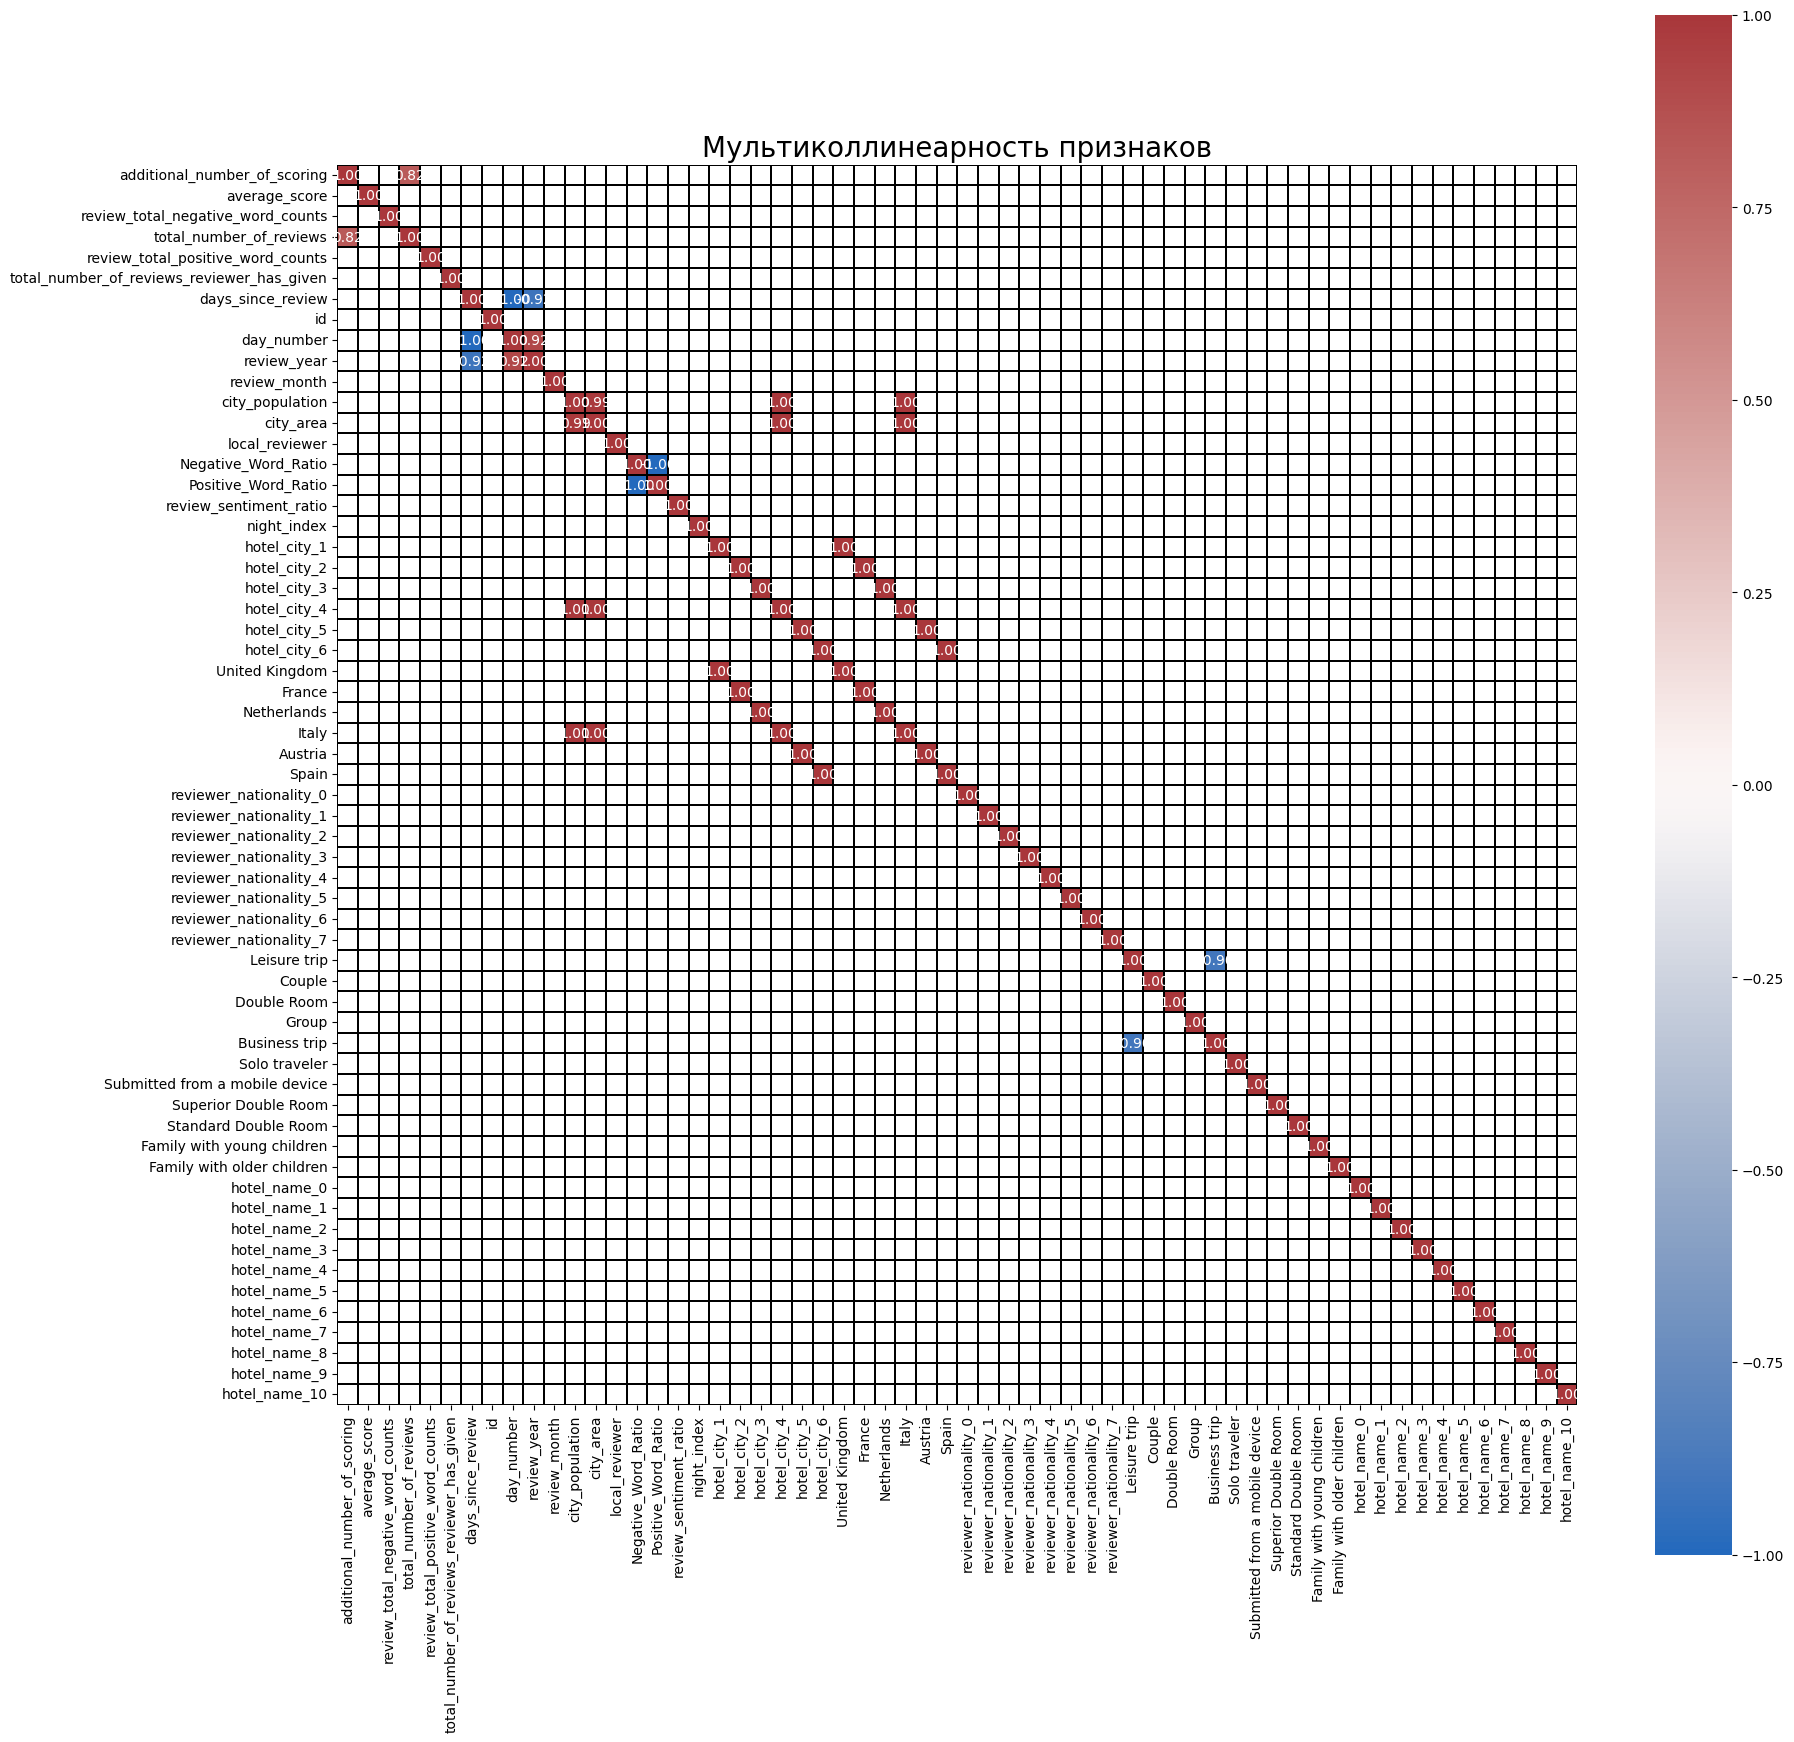

In [37]:
# Построим тепловую корреляционную матрицу и проанализируем данные на наличие мультиколлинеарности
# Данные для построения графика
corr = hotels_copy.drop(['reviewer_score', 'sample'], axis=1).corr()
plt.subplots(figsize=(20, 20))
# тепловая матрица с коэффициентами корреляции не менее 0.7
ax_heat_multicoll = sns.heatmap(
    corr[corr.abs() >= 0.7], 
    vmin=-1, 
    vmax=1, 
    linewidth=0.1, 
    linecolor='black', 
    cmap='vlag',
    annot = True,
    fmt='.2f',
    square=True
)

ax_heat_multicoll.set_title('Mультиколлинеарность признаков', fontsize=20);

In [38]:
# в парах с высокой мультиколлинеарностью удаляем 'additional_number_of_scoring', 'city_population','review_year',
#'hotel_city_1', 'hotel_city_2','hotel_city_3','hotel_city_4','hotel_city_5','hotel_city_6','Business trip'
# в результате остается day_since_review'
# оставляем один признак поездки 'leisure trip'
# также оставляем пару day_since_review' и 'day_number' 
hotels_copy.drop([
    'Business trip', 'additional_number_of_scoring', 
    'сity_population', 'review_year', 'hotel_city_1',
    'hotel_city_2','hotel_city_3','hotel_city_4','hotel_city_5','hotel_city_6'], 
    axis=1, inplace=True)

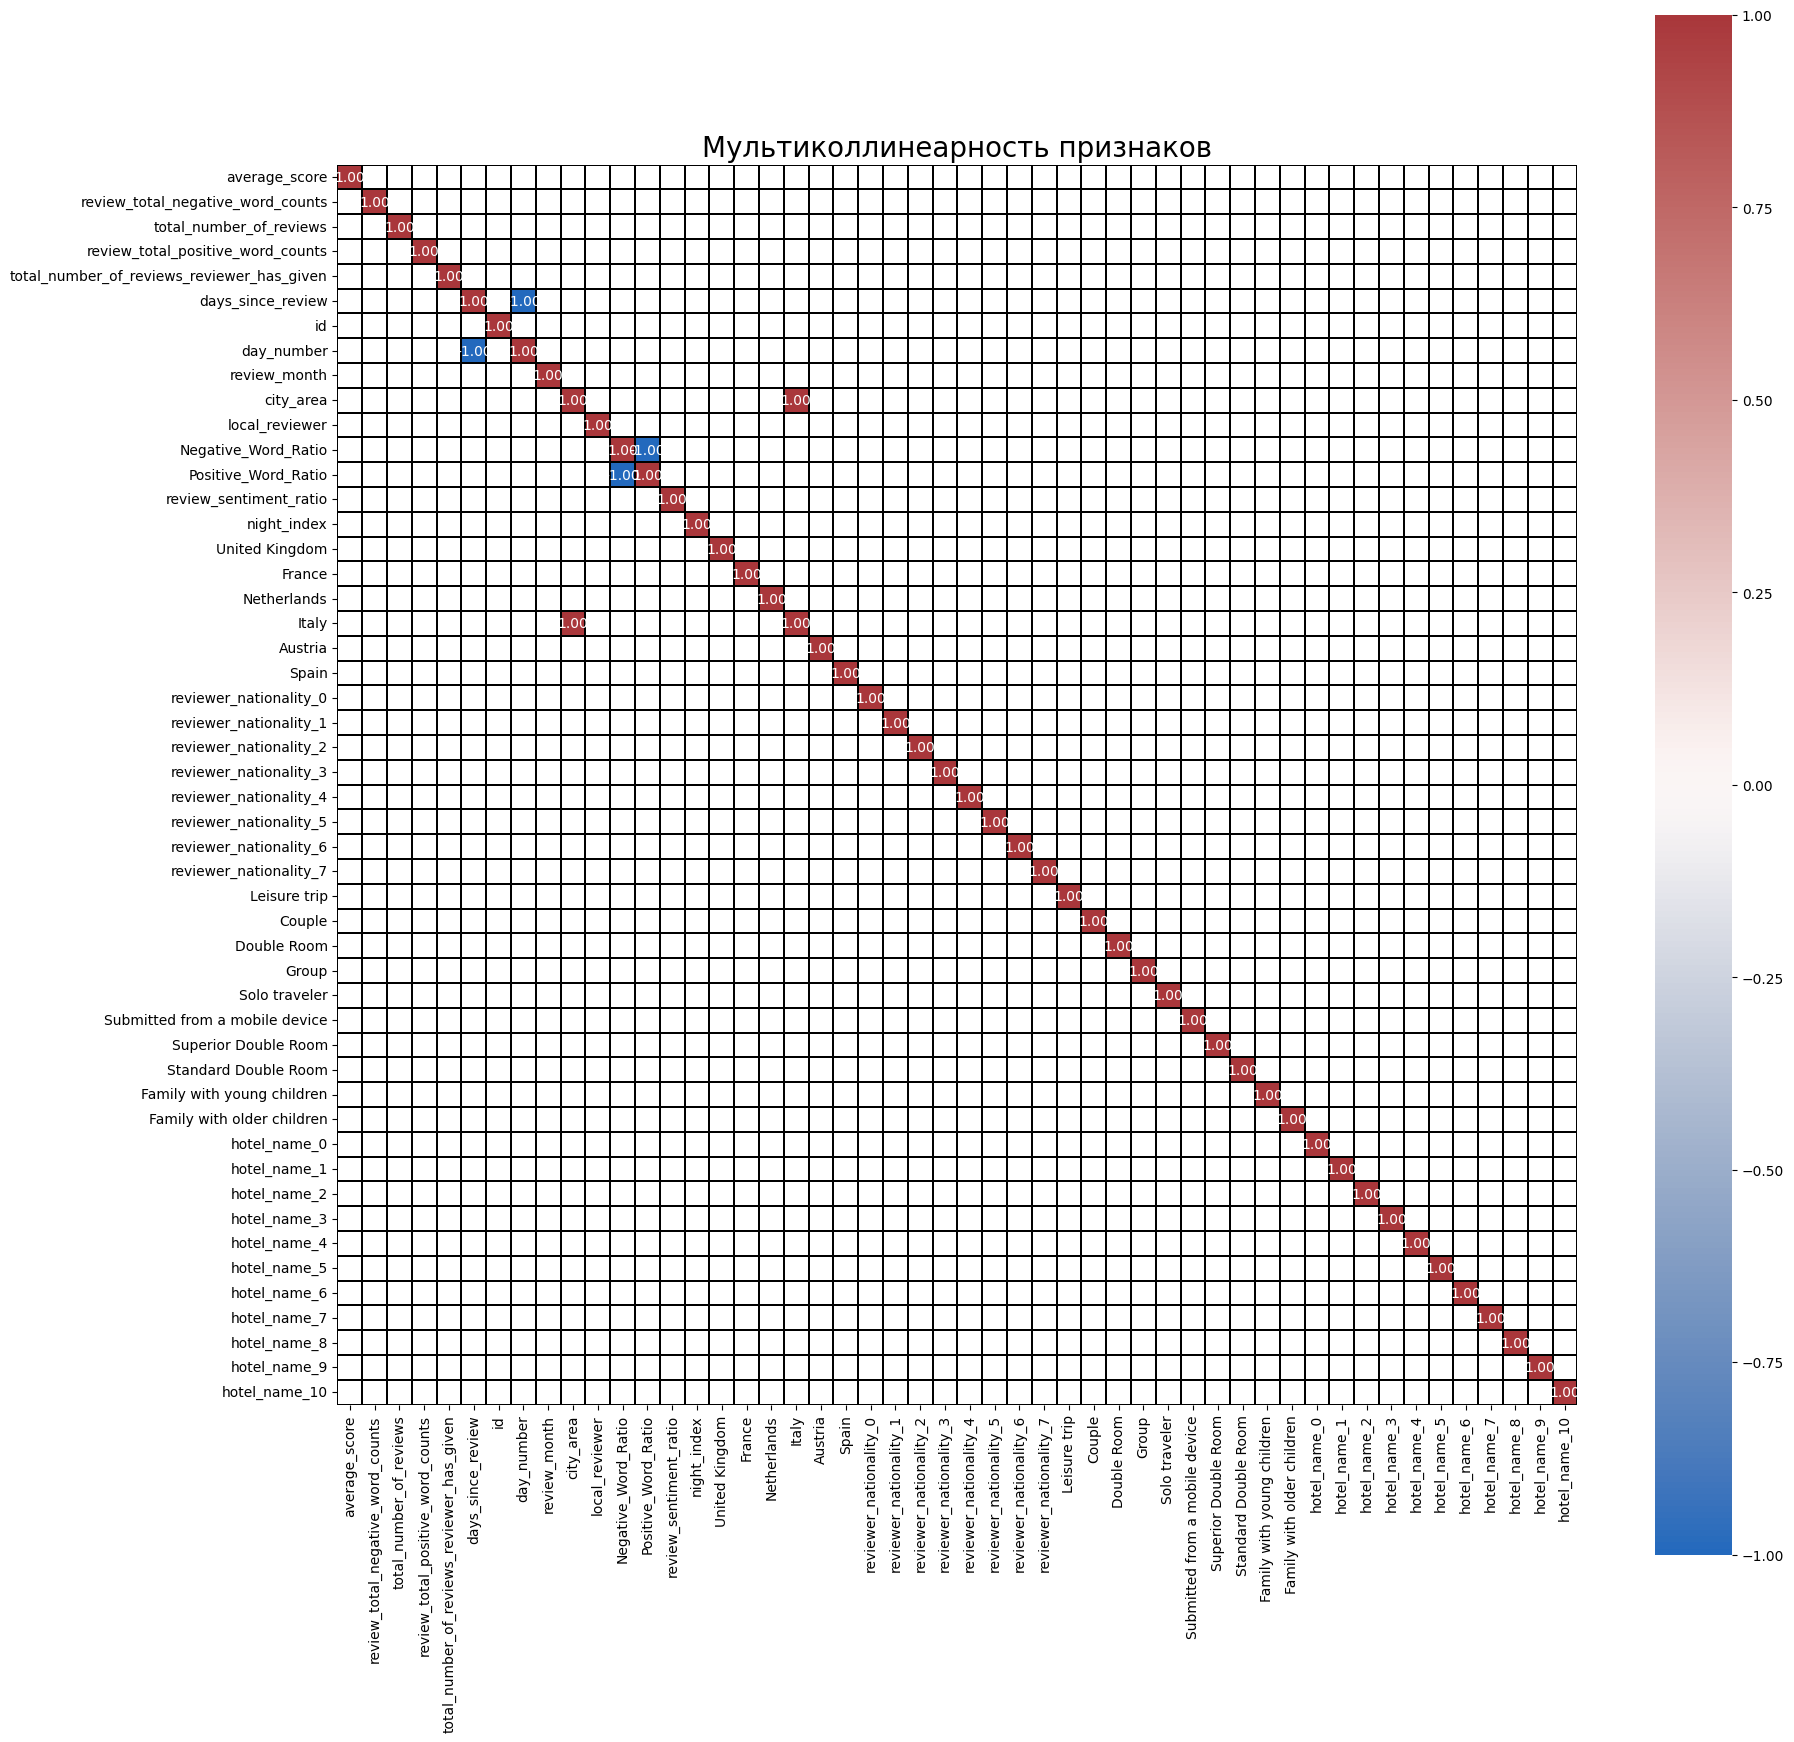

In [39]:
# проверяем корреляцию
corr = hotels_copy.drop(['reviewer_score', 'sample'], axis=1).corr()
plt.subplots(figsize=(20, 20))
# тепловая матрица с коэффициентами корреляции не менее 0.7
ax_heat_multicoll = sns.heatmap(
    corr[corr.abs() >= 0.7], 
    vmin=-1, 
    vmax=1, 
    linewidth=0.1, 
    linecolor='black', 
    cmap='vlag',
    annot = True,
    fmt='.2f',
    square=True
)

ax_heat_multicoll.set_title('Mультиколлинеарность признаков', fontsize=20);

# 5. Создание и обучение регрессивной модели by RandomForestRegressor

In [40]:
# убираем признаки которые еще не успели обработать
object_columns = [i for i in hotels.columns if hotels[i].dtypes == 'object']

hotels.drop(object_columns, axis=1, inplace=True)
# заполняем пропуски самым простым способом
hotels = hotels.fillna(0)

In [41]:
# Теперь выделим тестовую часть
train_data = hotels.query('sample == 1').drop(['sample'], axis=1) 
test_data = hotels.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values # наша цель
X = train_data.drop(['reviewer_score'], axis=1)

In [42]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [43]:
# проверка
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 61), (386803, 61), (386803, 60), (309442, 60), (77361, 60))

In [44]:
# Создаём модель
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [45]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.1s finished


# 6. Эффективность модели

In [46]:
# Функция для рассчёта MAPE:
def mape(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [47]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.9343900931994156


In [48]:
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', mape(y_test, y_pred))

MAPE: 13.487069198306544


## Предсказание по тестовым данным

<Axes: >

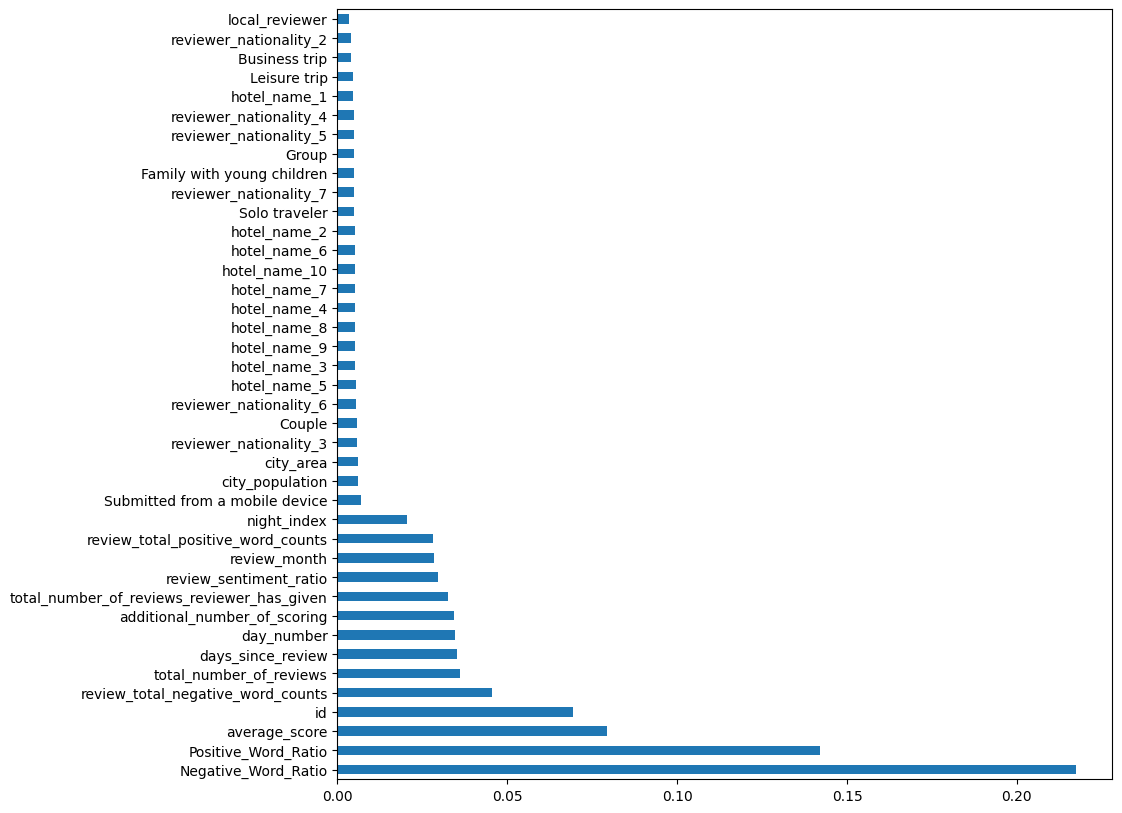

In [49]:
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(40).plot(kind='barh')

In [50]:
test_data.sample(10)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,id,reviewer_score,day_number,...,hotel_name_1,hotel_name_2,hotel_name_3,hotel_name_4,hotel_name_5,hotel_name_6,hotel_name_7,hotel_name_8,hotel_name_9,hotel_name_10
19700,713,8.3,14,2826,15,4,67,19700,0.0,663,...,0,0,0,1,1,0,1,1,0,1
27345,47,7.9,0,393,25,3,5,27345,0.0,725,...,1,0,0,1,0,1,0,1,0,0
78339,681,8.9,2,2692,8,8,630,78339,0.0,100,...,1,1,1,0,0,0,1,0,1,1
16557,832,9.1,3,4672,30,12,114,16557,0.0,616,...,0,1,0,0,0,0,1,1,1,0
11343,1936,8.7,14,7491,4,15,614,11343,0.0,116,...,0,0,0,0,1,0,0,1,1,0
77966,973,8.0,3,4820,36,6,401,77966,0.0,329,...,0,0,0,0,0,0,1,1,0,1
24583,390,7.8,0,1717,40,2,562,24583,0.0,168,...,0,0,0,1,1,1,1,0,0,0
115672,103,8.2,47,580,37,5,427,115672,0.0,303,...,1,0,1,1,1,0,0,1,1,1
29217,74,7.8,68,883,51,9,373,29217,0.0,357,...,1,1,1,1,0,1,0,0,0,1
61197,300,9.0,16,1254,0,4,696,61197,0.0,34,...,0,1,0,1,0,0,0,1,0,1


In [51]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [52]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [53]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    3.0s finished


In [54]:
predict_submission

array([8.212, 7.21 , 8.013, ..., 8.06 , 9.682, 6.96 ])

In [55]:
list(sample_submission)

['reviewer_score', 'id']

# 7. Подготовка сабмишена

In [56]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.212,488440
1,7.210,274649
2,8.013,374688
3,9.309,404352
4,9.143,451596
5,7.937,302161
6,7.990,317079
7,7.565,13963
8,8.560,159785
9,6.787,195089


### 